In [1]:
library(dplyr)
library(stringr)
library(Seurat) # Seurat v4.1.0
library(Matrix)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(ggbeeswarm)
library(ggpubr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



In [2]:
jz.checkgene = function(srat,gene){
    genes = rownames(srat)
    genes[startsWith(genes,gene)]
}

In [ ]:
group.pal = c('d30_60mer-PADRE'= '#e69f00', 'p60mer'='black')
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     plot.subtitle = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8, angle=45, hjust=1),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     legend.key.size = unit(.3, 'cm'),
                     #panel.border = element_rect(fill=NA,linewidth=.3,color='black'),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=0,color='black'),
                     axis.line = element_line(linewidth = .3),
                     axis.ticks = element_line(linewidth = 0.3))

In [3]:
srat = readRDS('seurat_objects/00_merged_seurat.RDS')
srat

An object of class Seurat 
16497 features across 6352 samples within 2 assays 
Active assay: RNA (16493 features, 0 variable features)
 4 layers present: counts.dna1, counts.dna2, counts.protein1, counts.protein2
 1 other assay present: HTO

In [8]:
head(srat@meta.data,1)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,HTO_maxID,HTO_secondID,HTO_margin,HTO_classification,HTO_classification.global,hash.ID,barcode,cell_id,percent.mt
,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
dna1_AAACCAAAGACCACGT-1,dna1,200,155,5,3,TotalSeq-C0302,TotalSeq-C0301,0.3798881,Negative,Negative,Negative,AAACCAAAGACCACGT-1,dna1_AAACCAAAGACCACGT-1,0


In [4]:
colnames(srat@meta.data)
table(srat$orig.ident, srat$HTO_classification.global)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "nCount_HTO"               
 [5] "nFeature_HTO"              "HTO_maxID"                
 [7] "HTO_secondID"              "HTO_margin"               
 [9] "HTO_classification"        "HTO_classification.global"
[11] "hash.ID"                   "barcode"                  
[13] "cell_id"

          
           Doublet Negative Singlet
  dna1         624      606    2234
  dna2         227      185     950
  protein1      92       93     349
  protein2     140      193     659

In [9]:
srat = subset(srat,subset=HTO_classification.global=='Singlet')
srat$group = ifelse(startsWith(srat$orig.ident, 'dna'),'d30_60mer-PADRE', 'p60mer')
srat$group = factor(srat$group, levels=c('p60mer','d30_60mer-PADRE'))
table(srat$orig.ident, srat$HTO_classification)

          
           TotalSeq-C0301 TotalSeq-C0302 TotalSeq-C0303 TotalSeq-C0304
  dna1                740             51           1268            175
  dna2                380            139             78            353
  protein1            177             90             12             70
  protein2            321             20             45            273

In [10]:
srat[["percent.mt"]] <- PercentageFeatureSet(srat, pattern = "^mt-")


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


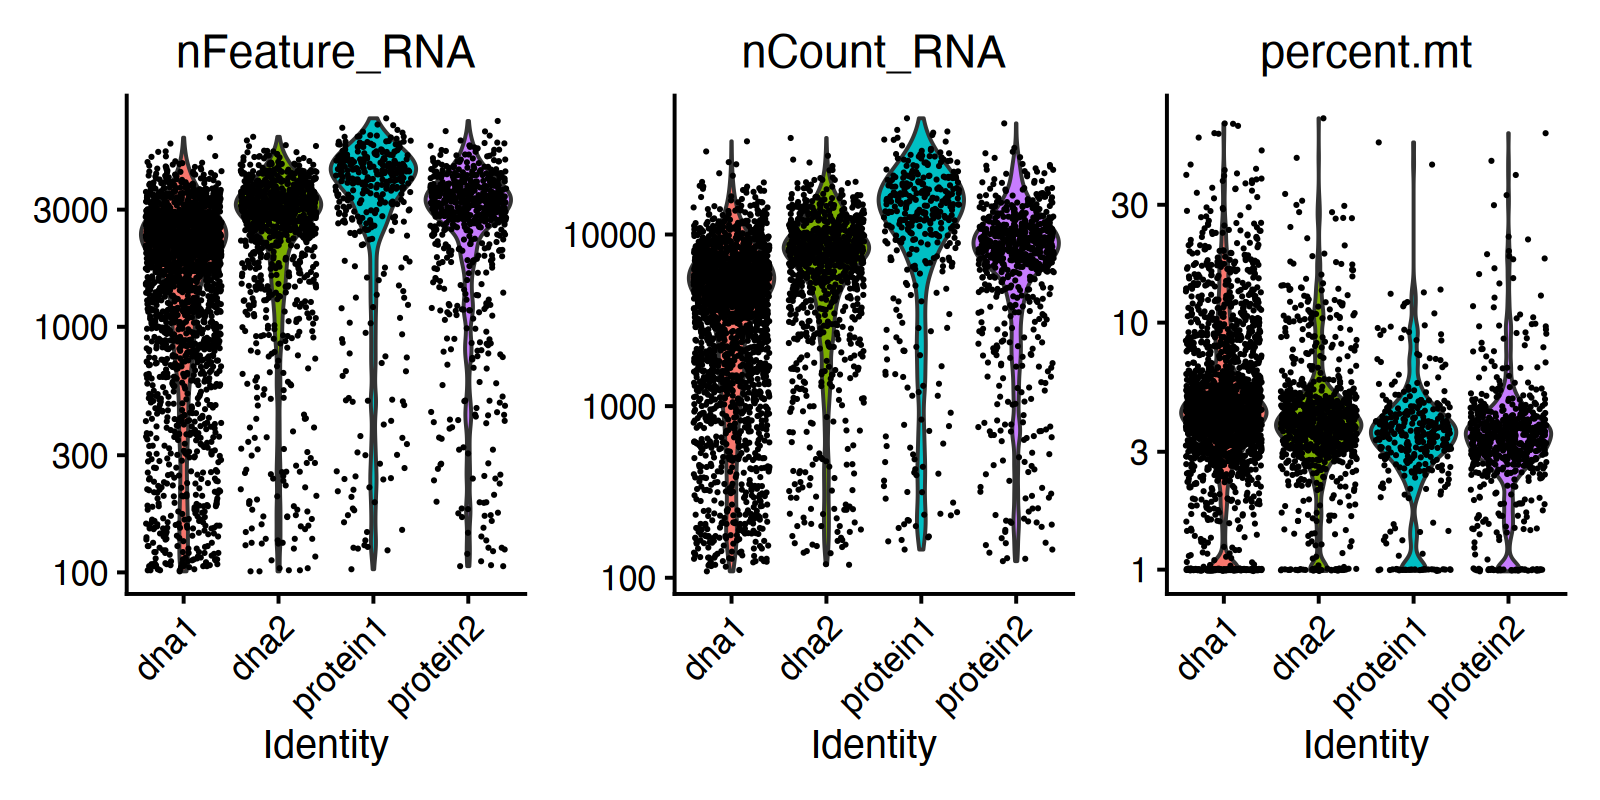

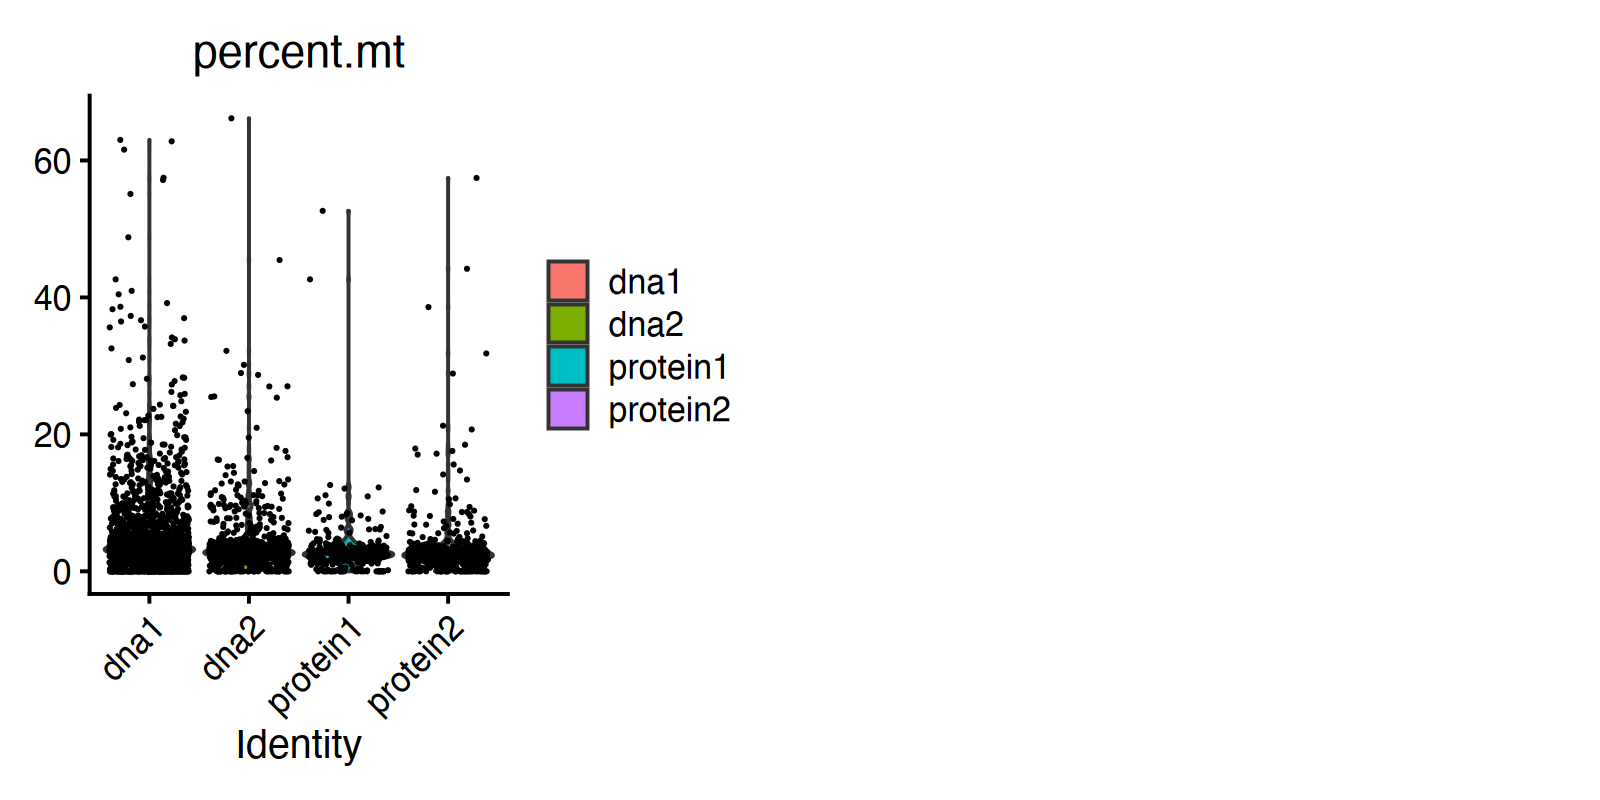

In [11]:
options(repr.plot.width=8, repr.plot.height=4,repr.plot.res=200)
Idents(srat) = 'orig.ident'
VlnPlot(srat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1, log = TRUE)
VlnPlot(srat, features = c("percent.mt"), ncol = 3, pt.size = 0.1)


In [12]:
srat[['RNA']] = JoinLayers(srat[['RNA']])
srat

An object of class Seurat 
16497 features across 4192 samples within 2 assays 
Active assay: RNA (16493 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO

In [13]:
srat <- NormalizeData(srat,verbose=FALSE)
srat <- FindVariableFeatures(srat,verbose=FALSE)
srat <- ScaleData(srat,vars.to.regress=c('nFeature_RNA','percent.mt'), verbose=FALSE)
srat <- RunPCA(srat,verbose=FALSE)

In [14]:
srat <- FindNeighbors(srat, dims = 1:30, verbose=FALSE)
srat <- RunUMAP(srat,dims = 1:30, verbose=FALSE)
srat <- FindClusters(srat, resolution = c(0.1,0.3,0.5, 0.7), verbose=FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


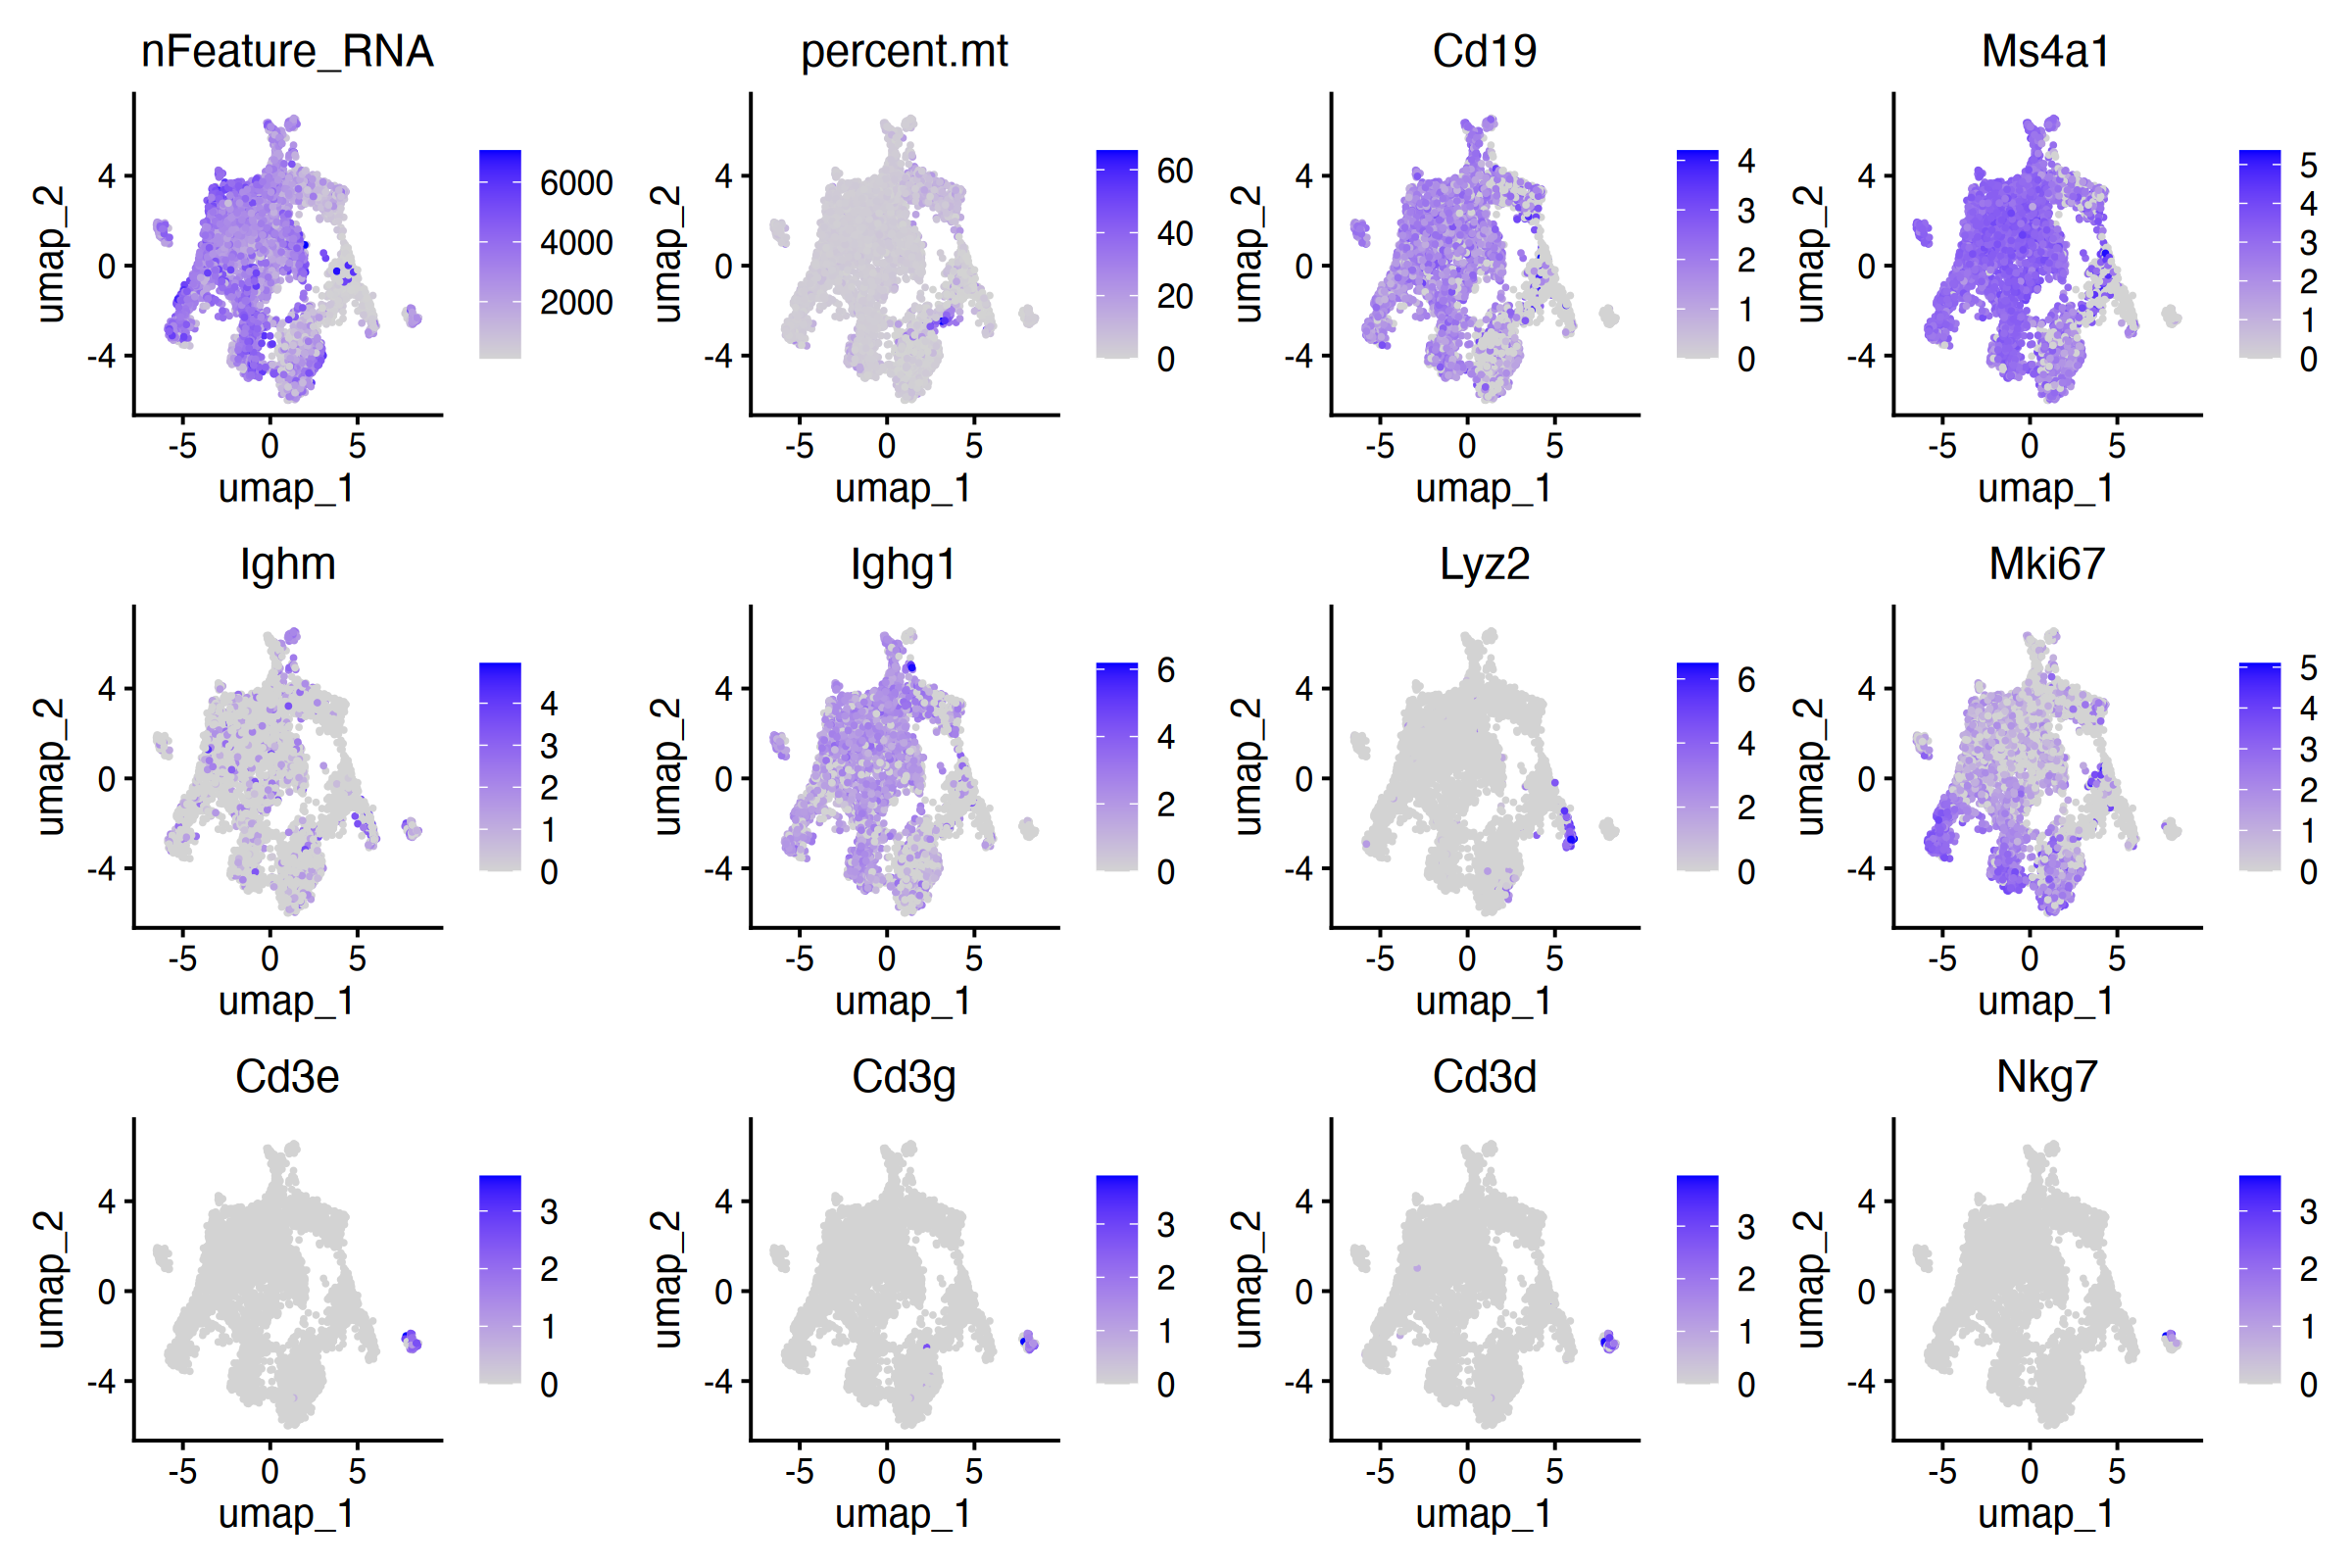

In [22]:
options(repr.plot.width=12, repr.plot.height=8)
FeaturePlot(srat,c('nFeature_RNA','percent.mt','Cd19','Ms4a1','Ighm','Ighg1','Lyz2','Mki67','Cd3e','Cd3g','Cd3d', 'Nkg7'))

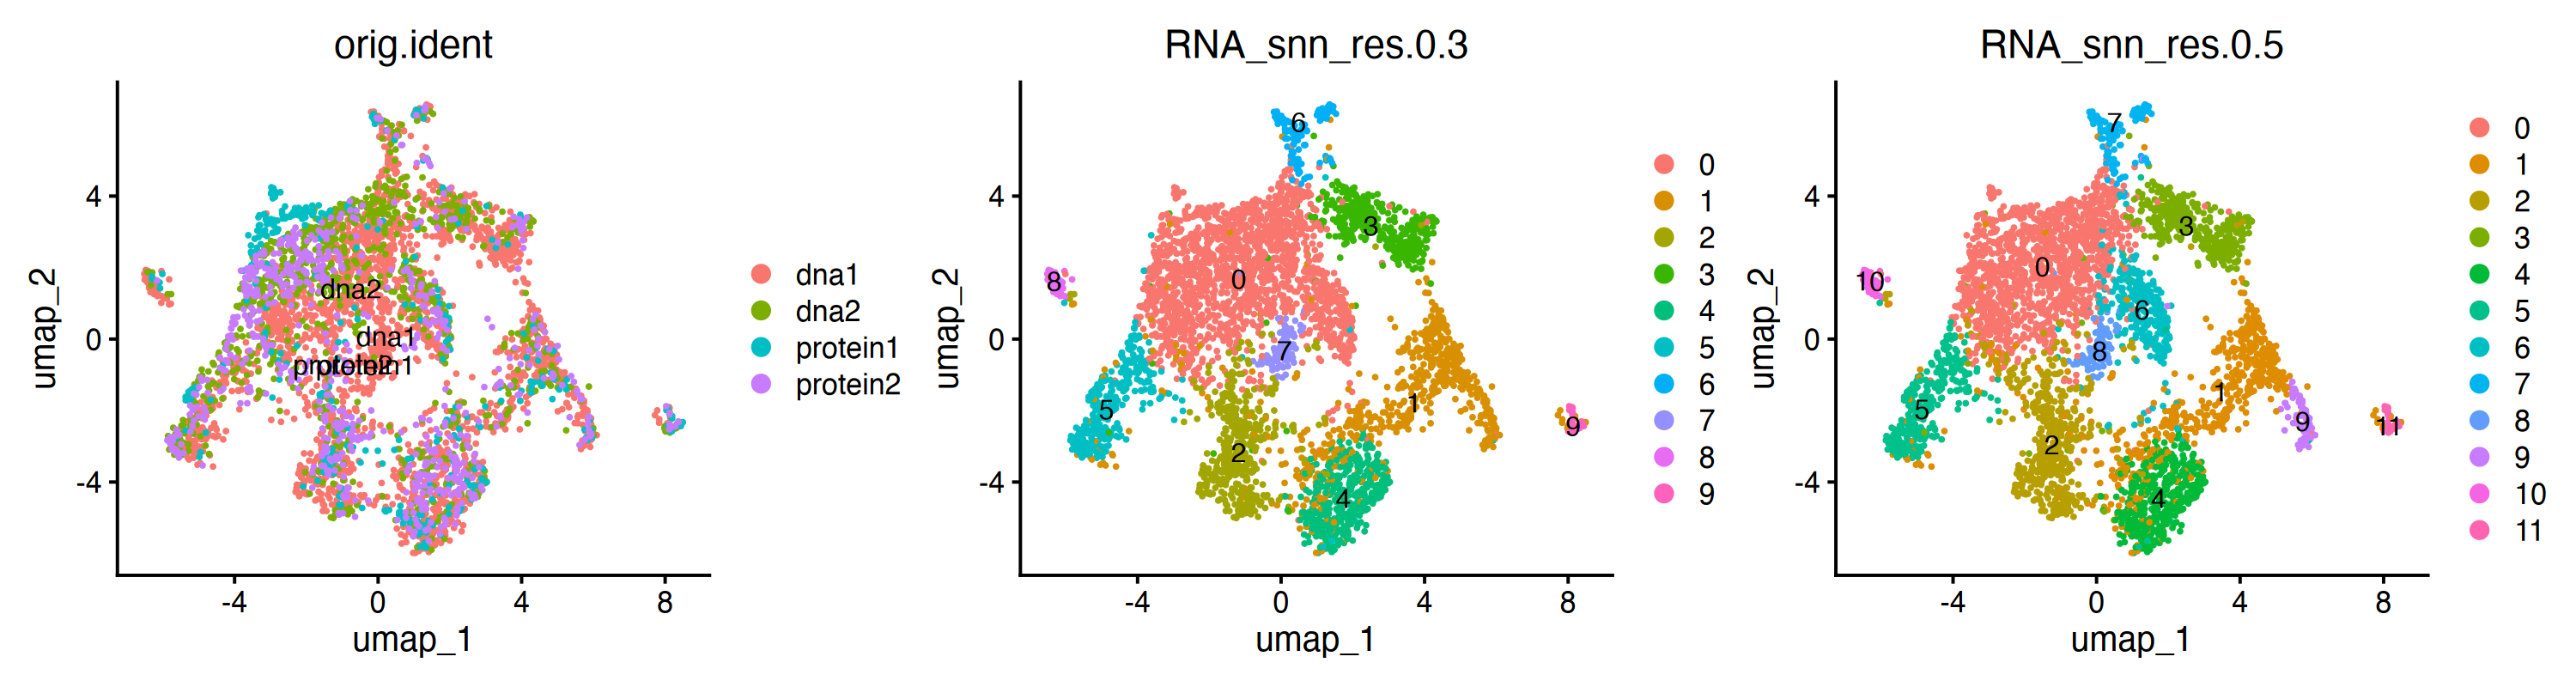

In [23]:
options(repr.plot.width=15, repr.plot.height=4)
DimPlot(srat, group.by=c('orig.ident','RNA_snn_res.0.3','RNA_snn_res.0.5'), label = TRUE)


In [25]:
srat$group = ifelse(startsWith(srat$orig.ident, 'dna'),'d30_60mer-PADRE', 'p60mer')
srat$group = factor(srat$group, levels=c('p60mer','d30_60mer-PADRE'))

In [26]:
saveRDS(srat, 'seurat_objects/01_QCed_seurat.RDS')